## Gaussian Process Regression

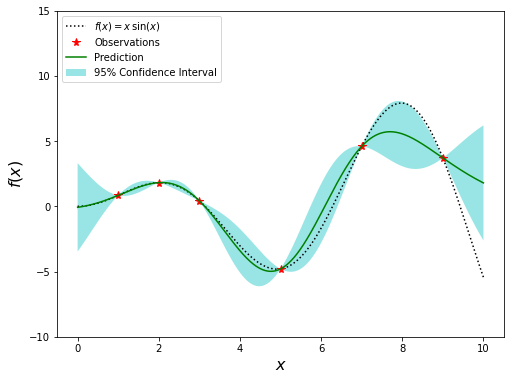

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

#  Input: X; observations: y
X = np.atleast_2d([1, 2, 3, 5, 7, 9]).T
y = (X*np.sin(X)).ravel()

# 1D mesh the input space 
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
fx = x * np.sin(x)

# Build a Gaussian Process model using a customized kernel and fit the data
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X, y)

# Make the prediction on the meshed x-axis 
y_pred, sigma = gp_model.predict(x, return_std=True)


def make_plot(X, y, y_pred, sigma, x, fx):
    # Plot the function, the prediction and the 95% confidence interval from GP
    plt.figure(figsize=(8,6))
    plt.plot(x, fx, 'k:', label='$f(x) = x\,\sin(x)$')
    plt.plot(X, y, 'r*', markersize=8, label='Observations')
    plt.plot(x, y_pred, 'g-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.96 * sigma, (y_pred + 1.96 * sigma)[::-1]]),
             alpha=.4, fc='c', ec='None', label='95% Confidence Interval')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.ylim(-10, 15)
    plt.legend(loc='upper left')
    return

make_plot(X, y, y_pred, sigma, x, fx)
plt.show()

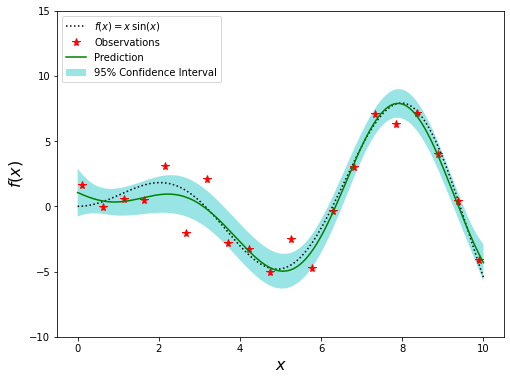

In [2]:
# THE NOISY CASE

X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = (X*np.sin(X)).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)

# Define the noise
np.random.seed(1)
noise = np.random.normal(0, dy)
y += noise

# Build a Gaussian Process model using the same kernel and fit the data
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=10)
gp_model.fit(X, y)

# Make the prediction on the meshed x-axis 
y_pred, sigma = gp_model.predict(x, return_std=True)

# Plot the results
make_plot(X, y, y_pred, sigma, x, fx)
plt.show()

## Ensemble Learning Models for Regression

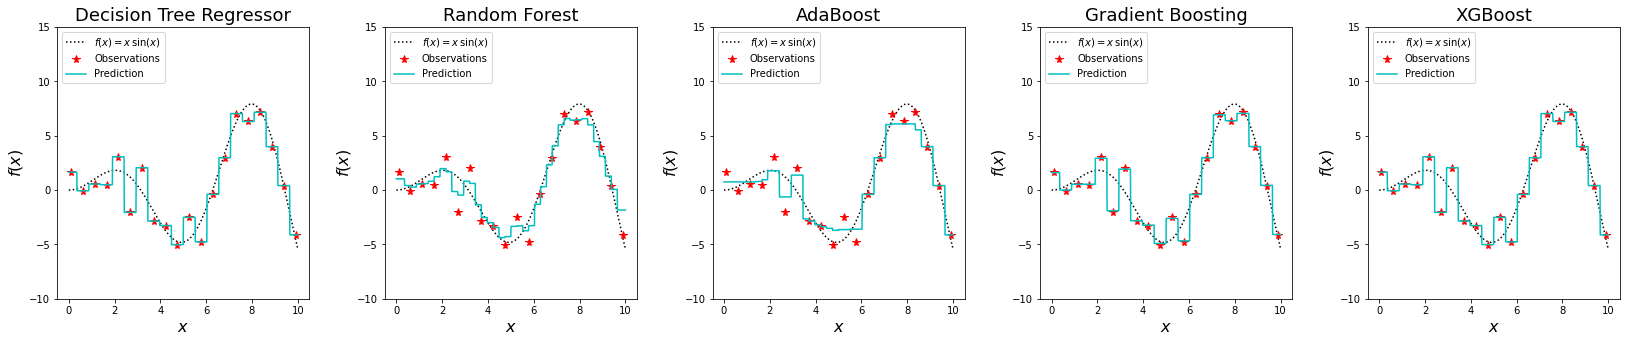

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

reg_models = (DecisionTreeRegressor(),
              RandomForestRegressor(),
              AdaBoostRegressor(),
              GradientBoostingRegressor(),
              xgb.XGBRegressor(n_jobs=3))

reg_models = (reg.fit(X, y) for reg in reg_models)

# title for the plots
titles = ('Decision Tree Regressor',
          'Random Forest',
          'AdaBoost',
          'Gradient Boosting',
          'XGBoost')
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(28,5))
fig.subplots_adjust(wspace=0.3)
# set the step size of the mesh grid as h
h = 0.02

for model, title, ax in zip(reg_models, titles, axes):
    y_pred = model.predict(x)
    ax.plot(x, fx, 'k:', label='$f(x) = x\,\sin(x)$')
    ax.plot(X, y, 'r*', markersize=8, label='Observations')
    ax.plot(x, y_pred, 'c-', label='Prediction')
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$f(x)$', fontsize=16)
    ax.set_ylim(-10, 15)
    ax.legend(loc='upper left')    
    ax.set_title(title, fontsize=18)
plt.show()



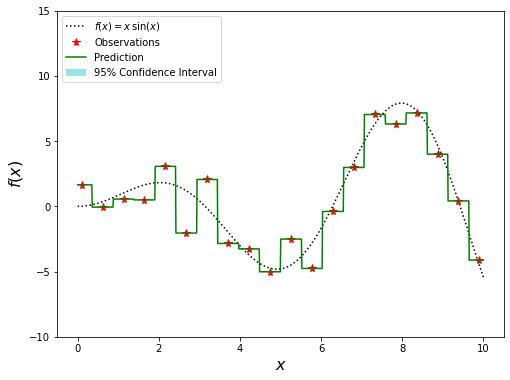

In [4]:
import xgboost as xgb

# Build a CART model and fit the data
xgb_model = xgb.XGBRegressor(n_jobs=3)
xgb_model.fit(X, y)

# Make the prediction on the meshed x-axis 
y_pred = xgb_model.predict(x)

sigma = np.zeros(sigma.shape)
# Plot the results
make_plot(X, y, y_pred, sigma, x, fx)

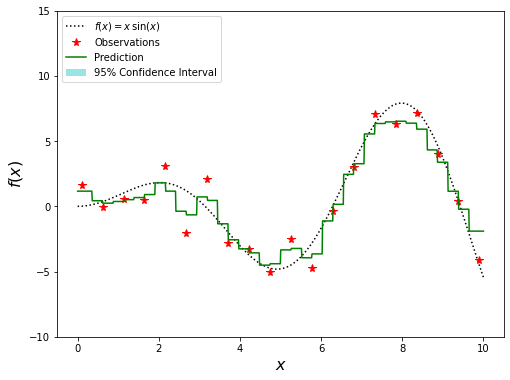

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Build a random forest model and fit the data
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Make the prediction on the meshed x-axis 
y_pred = rf_model.predict(x)

sigma = np.zeros(sigma.shape)
# Plot the results
make_plot(X, y, y_pred, sigma, x, fx)